# Note:

Here we first get the trajectories of Tubuli and Glomeruli and then we combine the time and use the combination for finding morpholagical features.

* It should note PILOT creats split folder for each data set and puts the all results there.
* We use "extract_data_anno_pathomics_from_h5ad" for loading needed data.
* You need to set the interestd names for morphological features (var_names), name of the sampleID column, cell_type/clustering column and status.

In [1]:
from PILOT import *
warnings.filterwarnings('ignore')

# Tubuli

## Load data

In [2]:
adata=load_h5ad('Datasets/Kidney_IgAN_T.h5ad') #First read the object
data_tubuli,annot_tubuli,path_to_results=extract_data_anno_pathomics_from_h5ad(adata,var_names=list(adata.var_names),clusters_col='Cell_type',sample_col='sampleID',status='status' ,name_dataset='Kidney_IgAN_T')

### Cluster representations by estimating regularized probability distributions of cell types per sample:

In [3]:
Clu_rep = Cluster_Representations(annot_tubuli,regulizer = 0.1,regularization=True) # Regularization

### Calcuating  cost matrix between clusters:

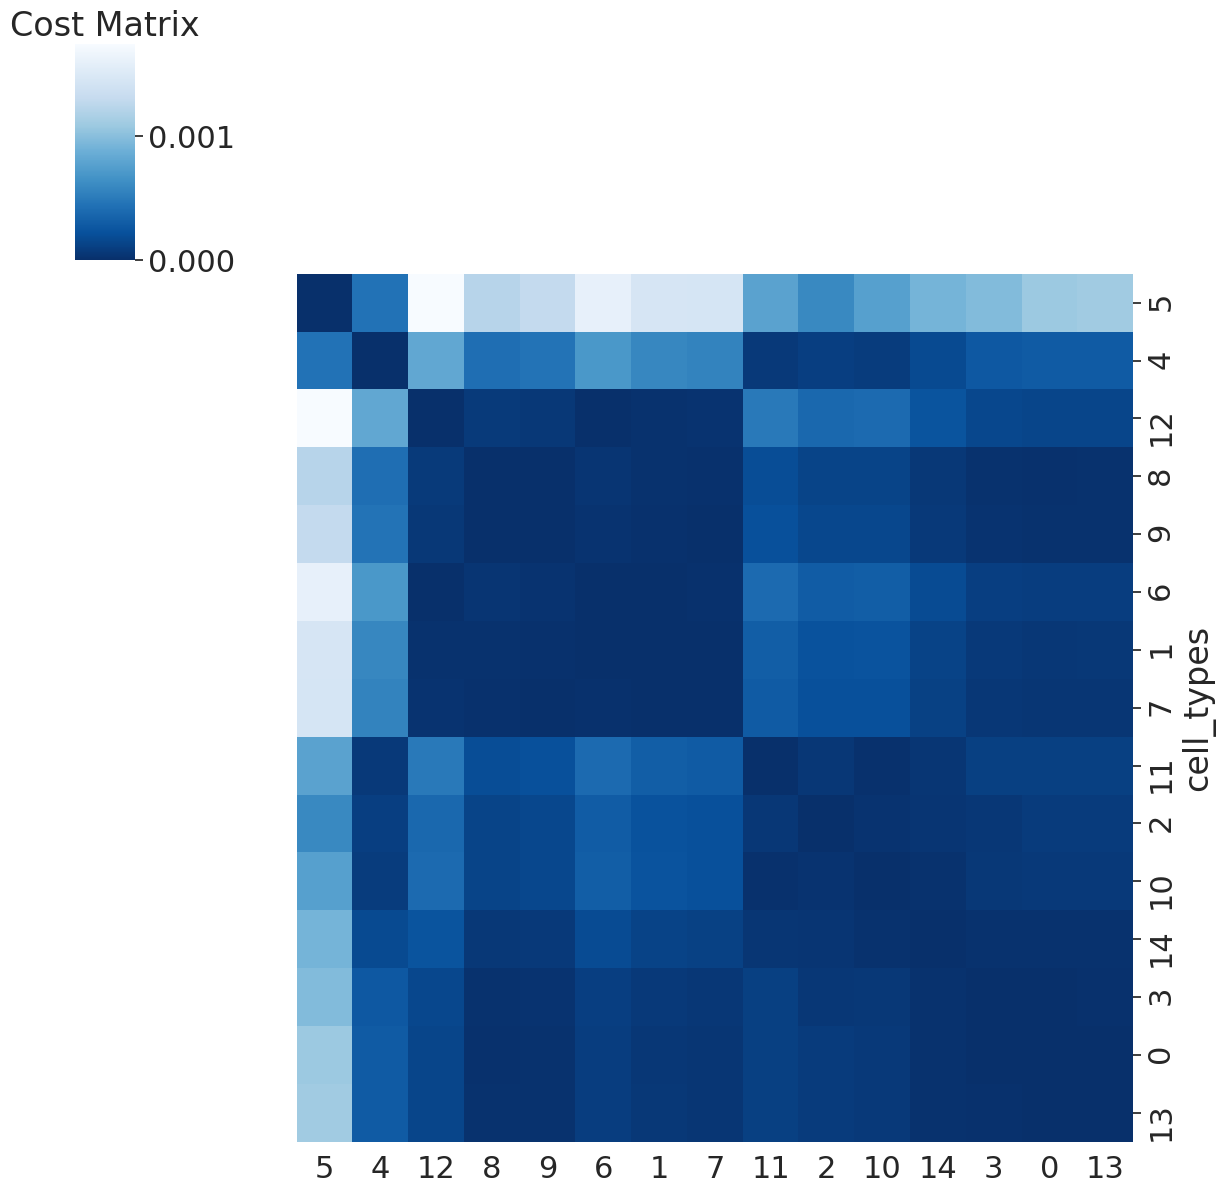

In [4]:
dis= cost_matrix(annot_tubuli, data_tubuli,path_to_results,cell_col = 0)

###  Estimate the Wasserstein distance:

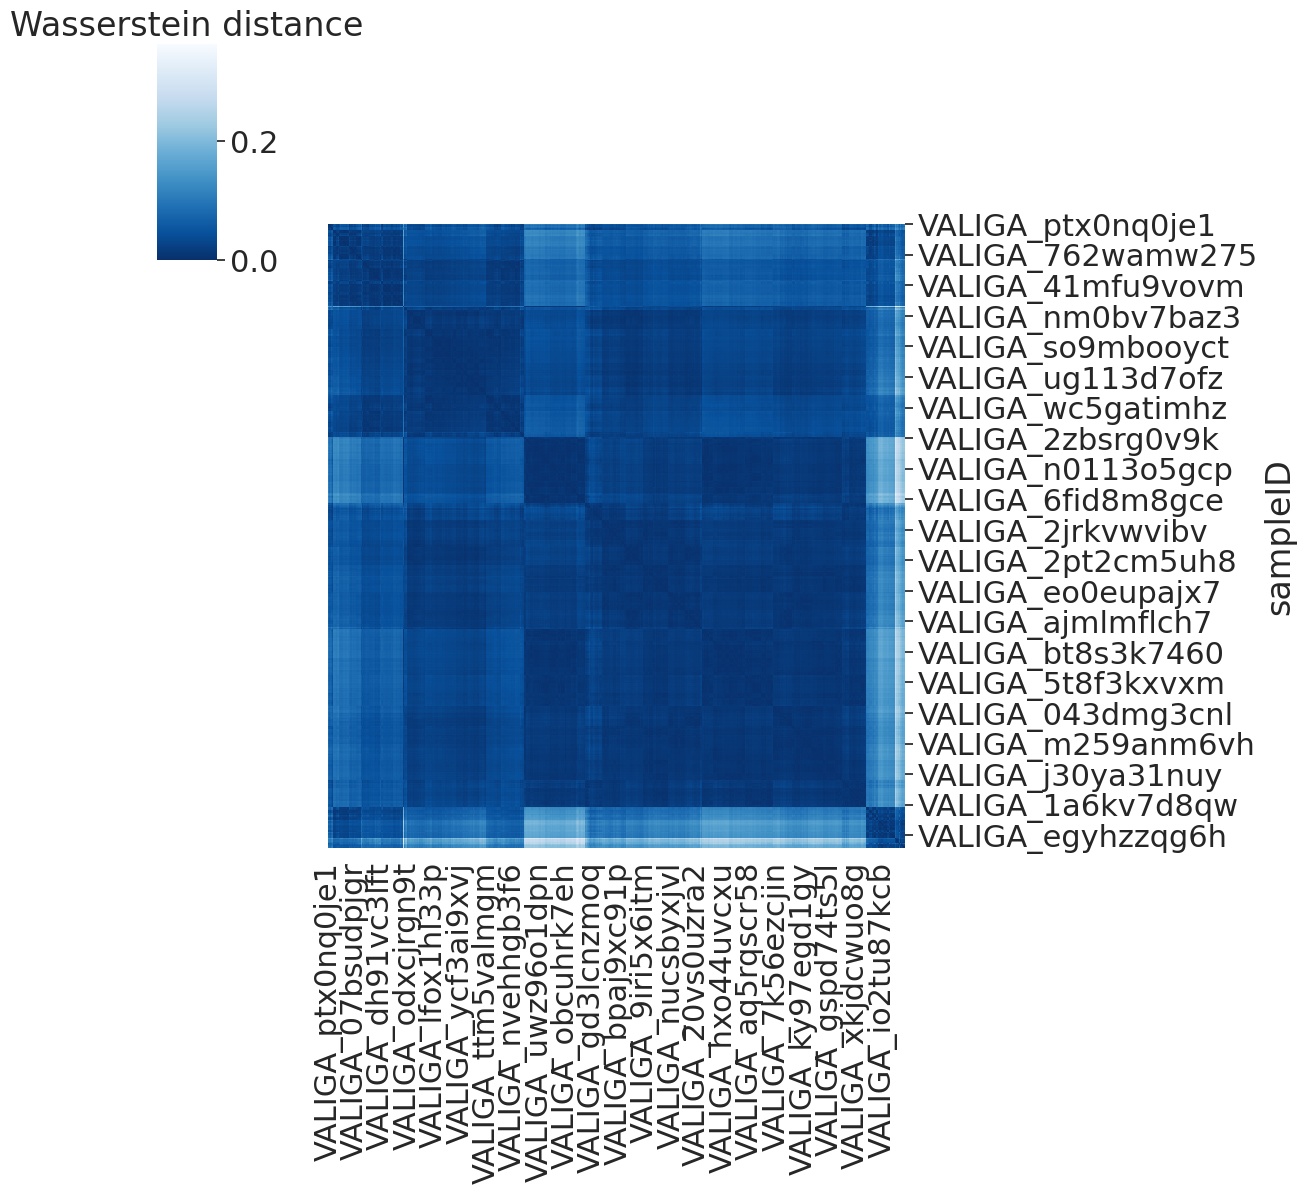

In [5]:
EMD = wasserstein_d(Clu_rep,dis/dis.max(),regularized = 'unreg',path = path_to_results)

### Evaluation

         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
Cluster labels:  ['<30', '>60', '30-60']
Categories (3, object): ['30-60', '<30', '>60']
ARI:  0.5832772686271871
Silhouette score:  0.10287634362960485


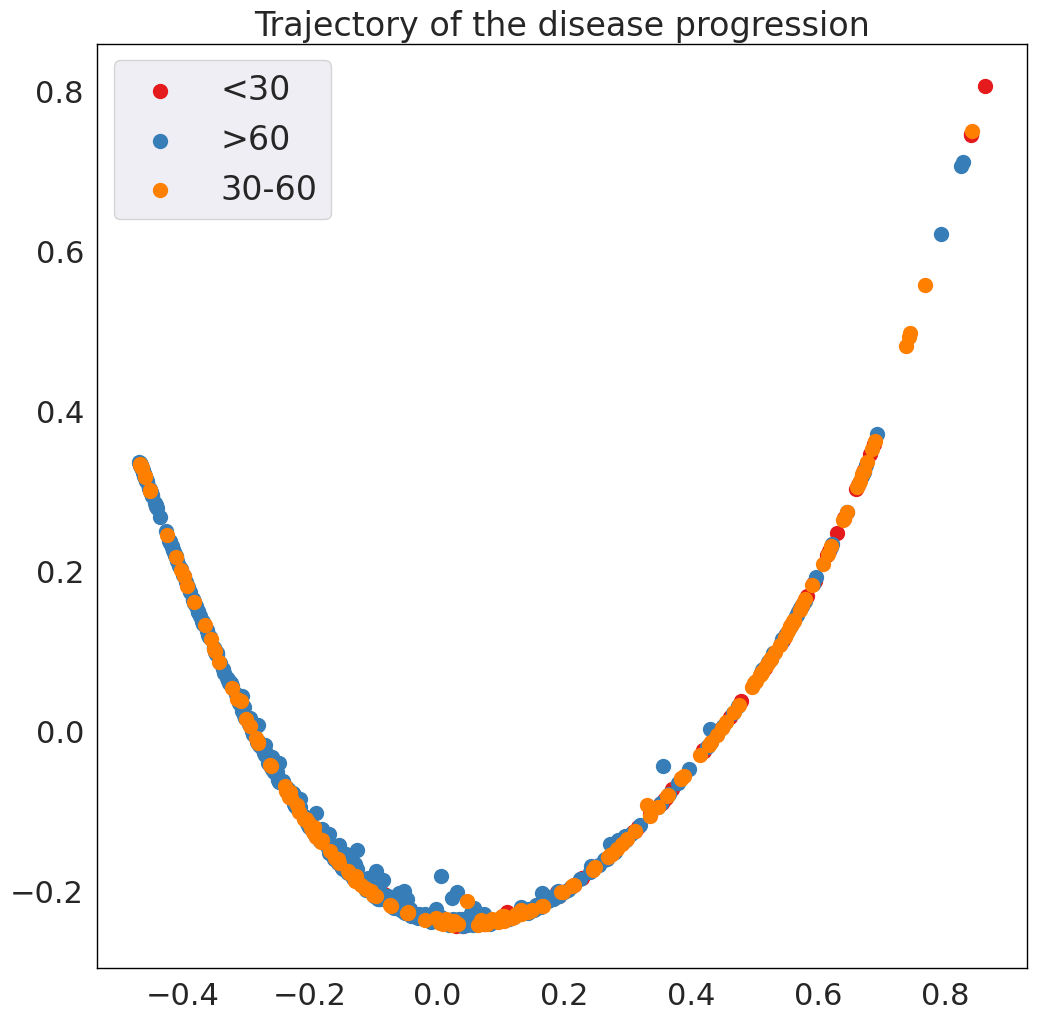

In [6]:
# Computing ARI
predicted_labels, ARI, real_labels = Clustering(EMD/EMD.max(), annot_tubuli,category ='status', sample_col=1, res = 0.01)
#Computing Sil
Silhouette = Sil_computing(EMD/EMD.max(), real_labels, metric = 'cosine',space = 'diffusion')

#Drawing diffusion map
emd_tubuli=trajectory(EMD/EMD.max(), predicted_labels, annot_tubuli, embed_coord = 'diffusion',path = path_to_results,label_act=False,location_labels='best',colors=['#e41a1c','#377eb8','#ff7f00'] )


# Glomeruli

## Load data

In [7]:

adata=load_h5ad('Datasets/Kidney_IgAN_G.h5ad')
data_glom,annot_glom,path_to_results=extract_data_anno_pathomics_from_h5ad(adata,var_names=list(adata.var_names),clusters_col='Cell_type',sample_col='sampleID',status='status' ,name_dataset='Kidney_IgAN_G')


### Cluster representations by estimating regularized probability distributions of cell types per sample:

In [8]:
Clu_rep = Cluster_Representations(annot_glom,regulizer = 0.1,regularization=True) # Regularization

### Calcuating  cost matrix between clusters:

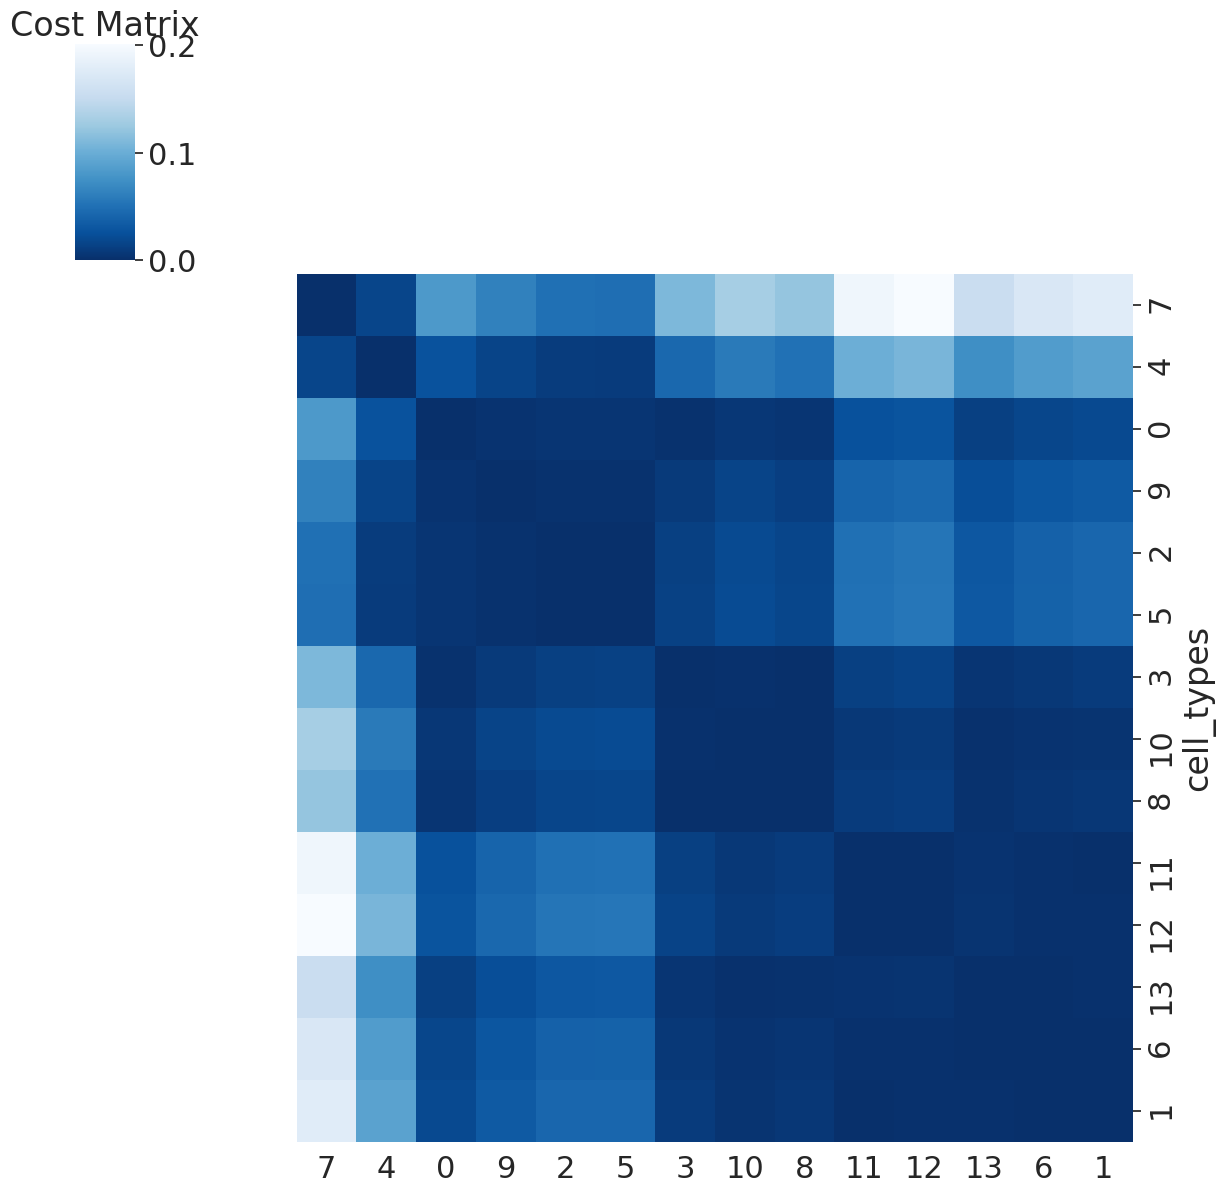

In [9]:
dis= cost_matrix(annot_glom, data_glom,path_to_results,cell_col = 0)

###  Estimate the Wasserstein distance:

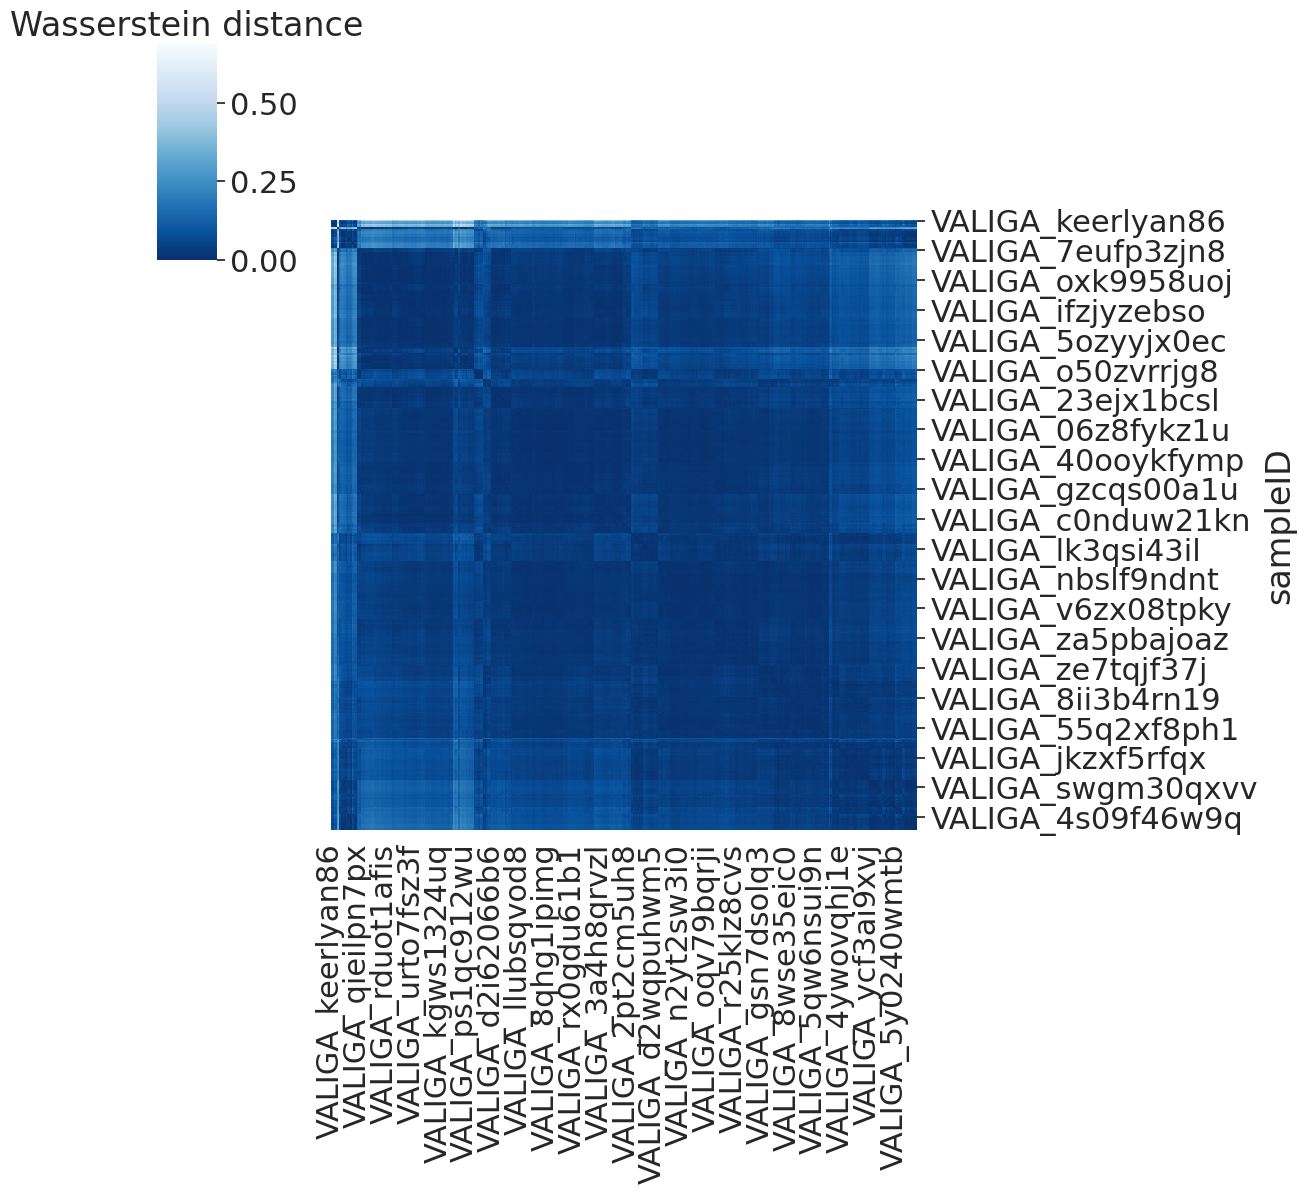

In [10]:
EMD = wasserstein_d(Clu_rep,dis/dis.max(),regularized = 'unreg',path = path_to_results)

### Evaluation

         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
Cluster labels:  ['<30', '>60', '30-60']
Categories (3, object): ['30-60', '<30', '>60']
ARI:  0.5562466049705722
Silhouette score:  0.07819445823579363


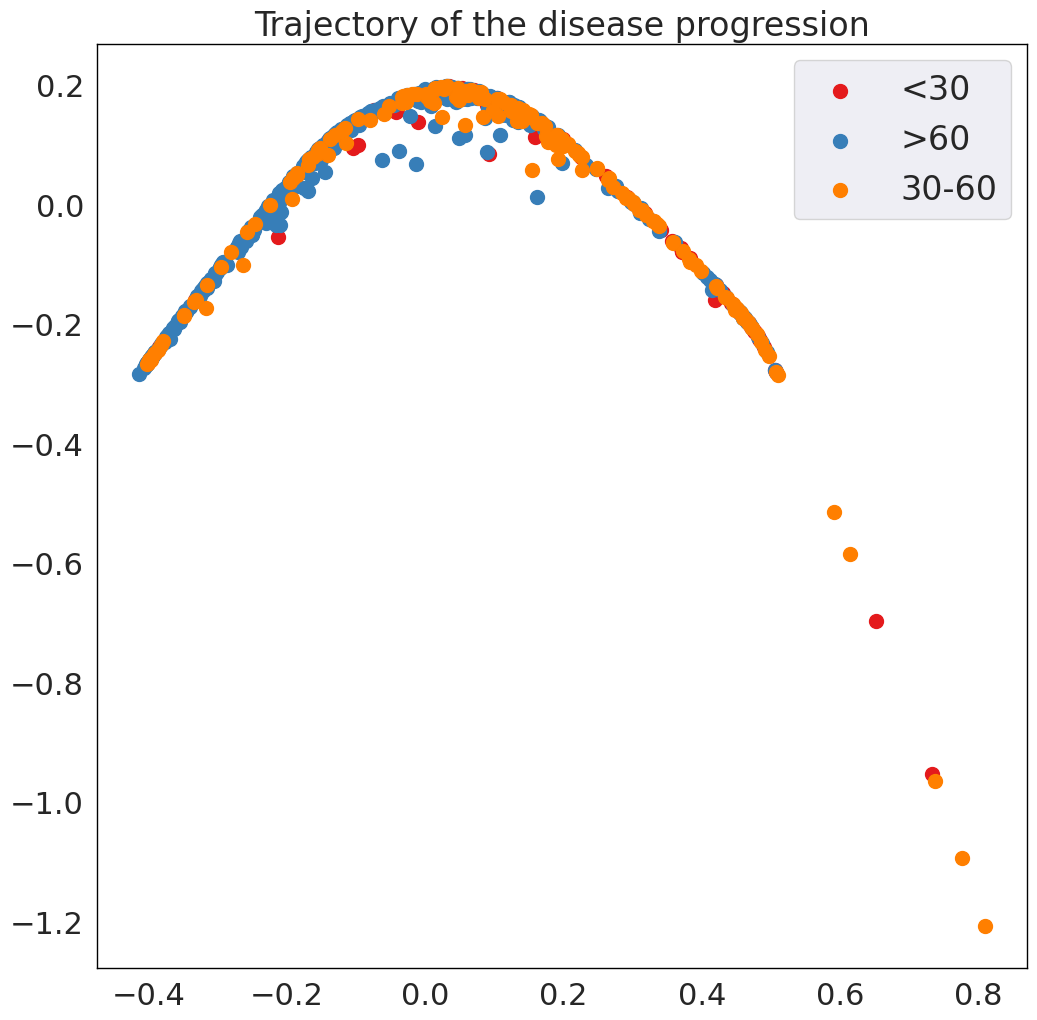

In [13]:
# Computing ARI
predicted_labels, ARI, real_labels = Clustering(EMD/EMD.max(), annot_glom,category ='status', sample_col=1, res = 0.01)
#Computing Sil
Silhouette = Sil_computing(EMD/EMD.max(), real_labels, metric = 'cosine',space = 'diffusion')

#Drawing diffusion map
emd_glomeruli=trajectory(EMD/EMD.max(), predicted_labels, annot_glom, embed_coord = 'diffusion',path = path_to_results,label_act=False,location_labels='best',colors=['#e41a1c','#377eb8','#ff7f00'] )


### Cell-type Importance Glomeruli:

* In this step we get the orders of samples

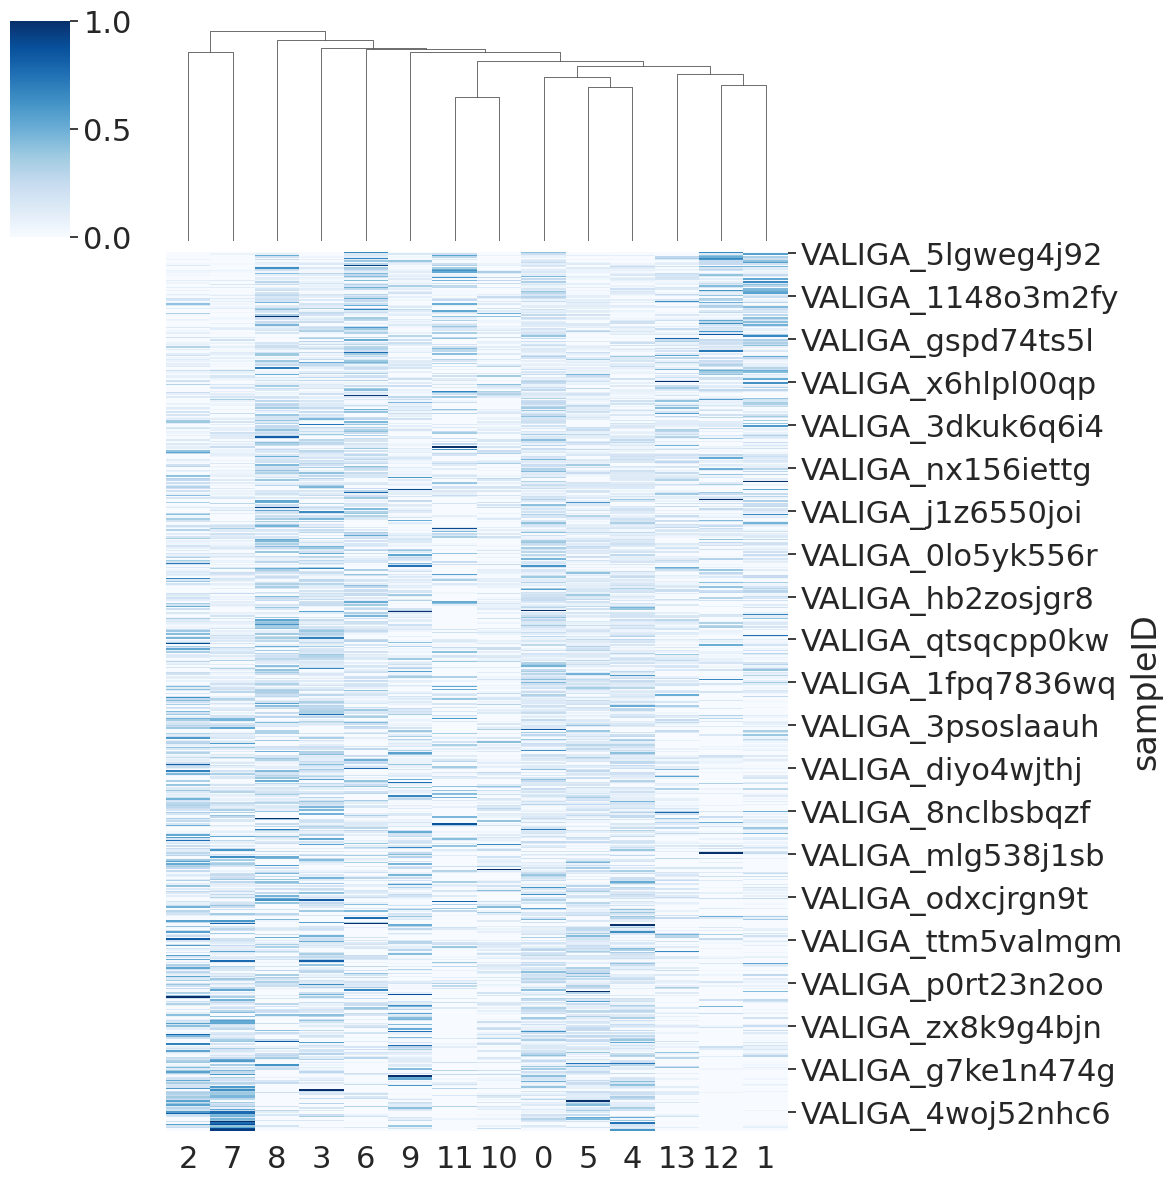

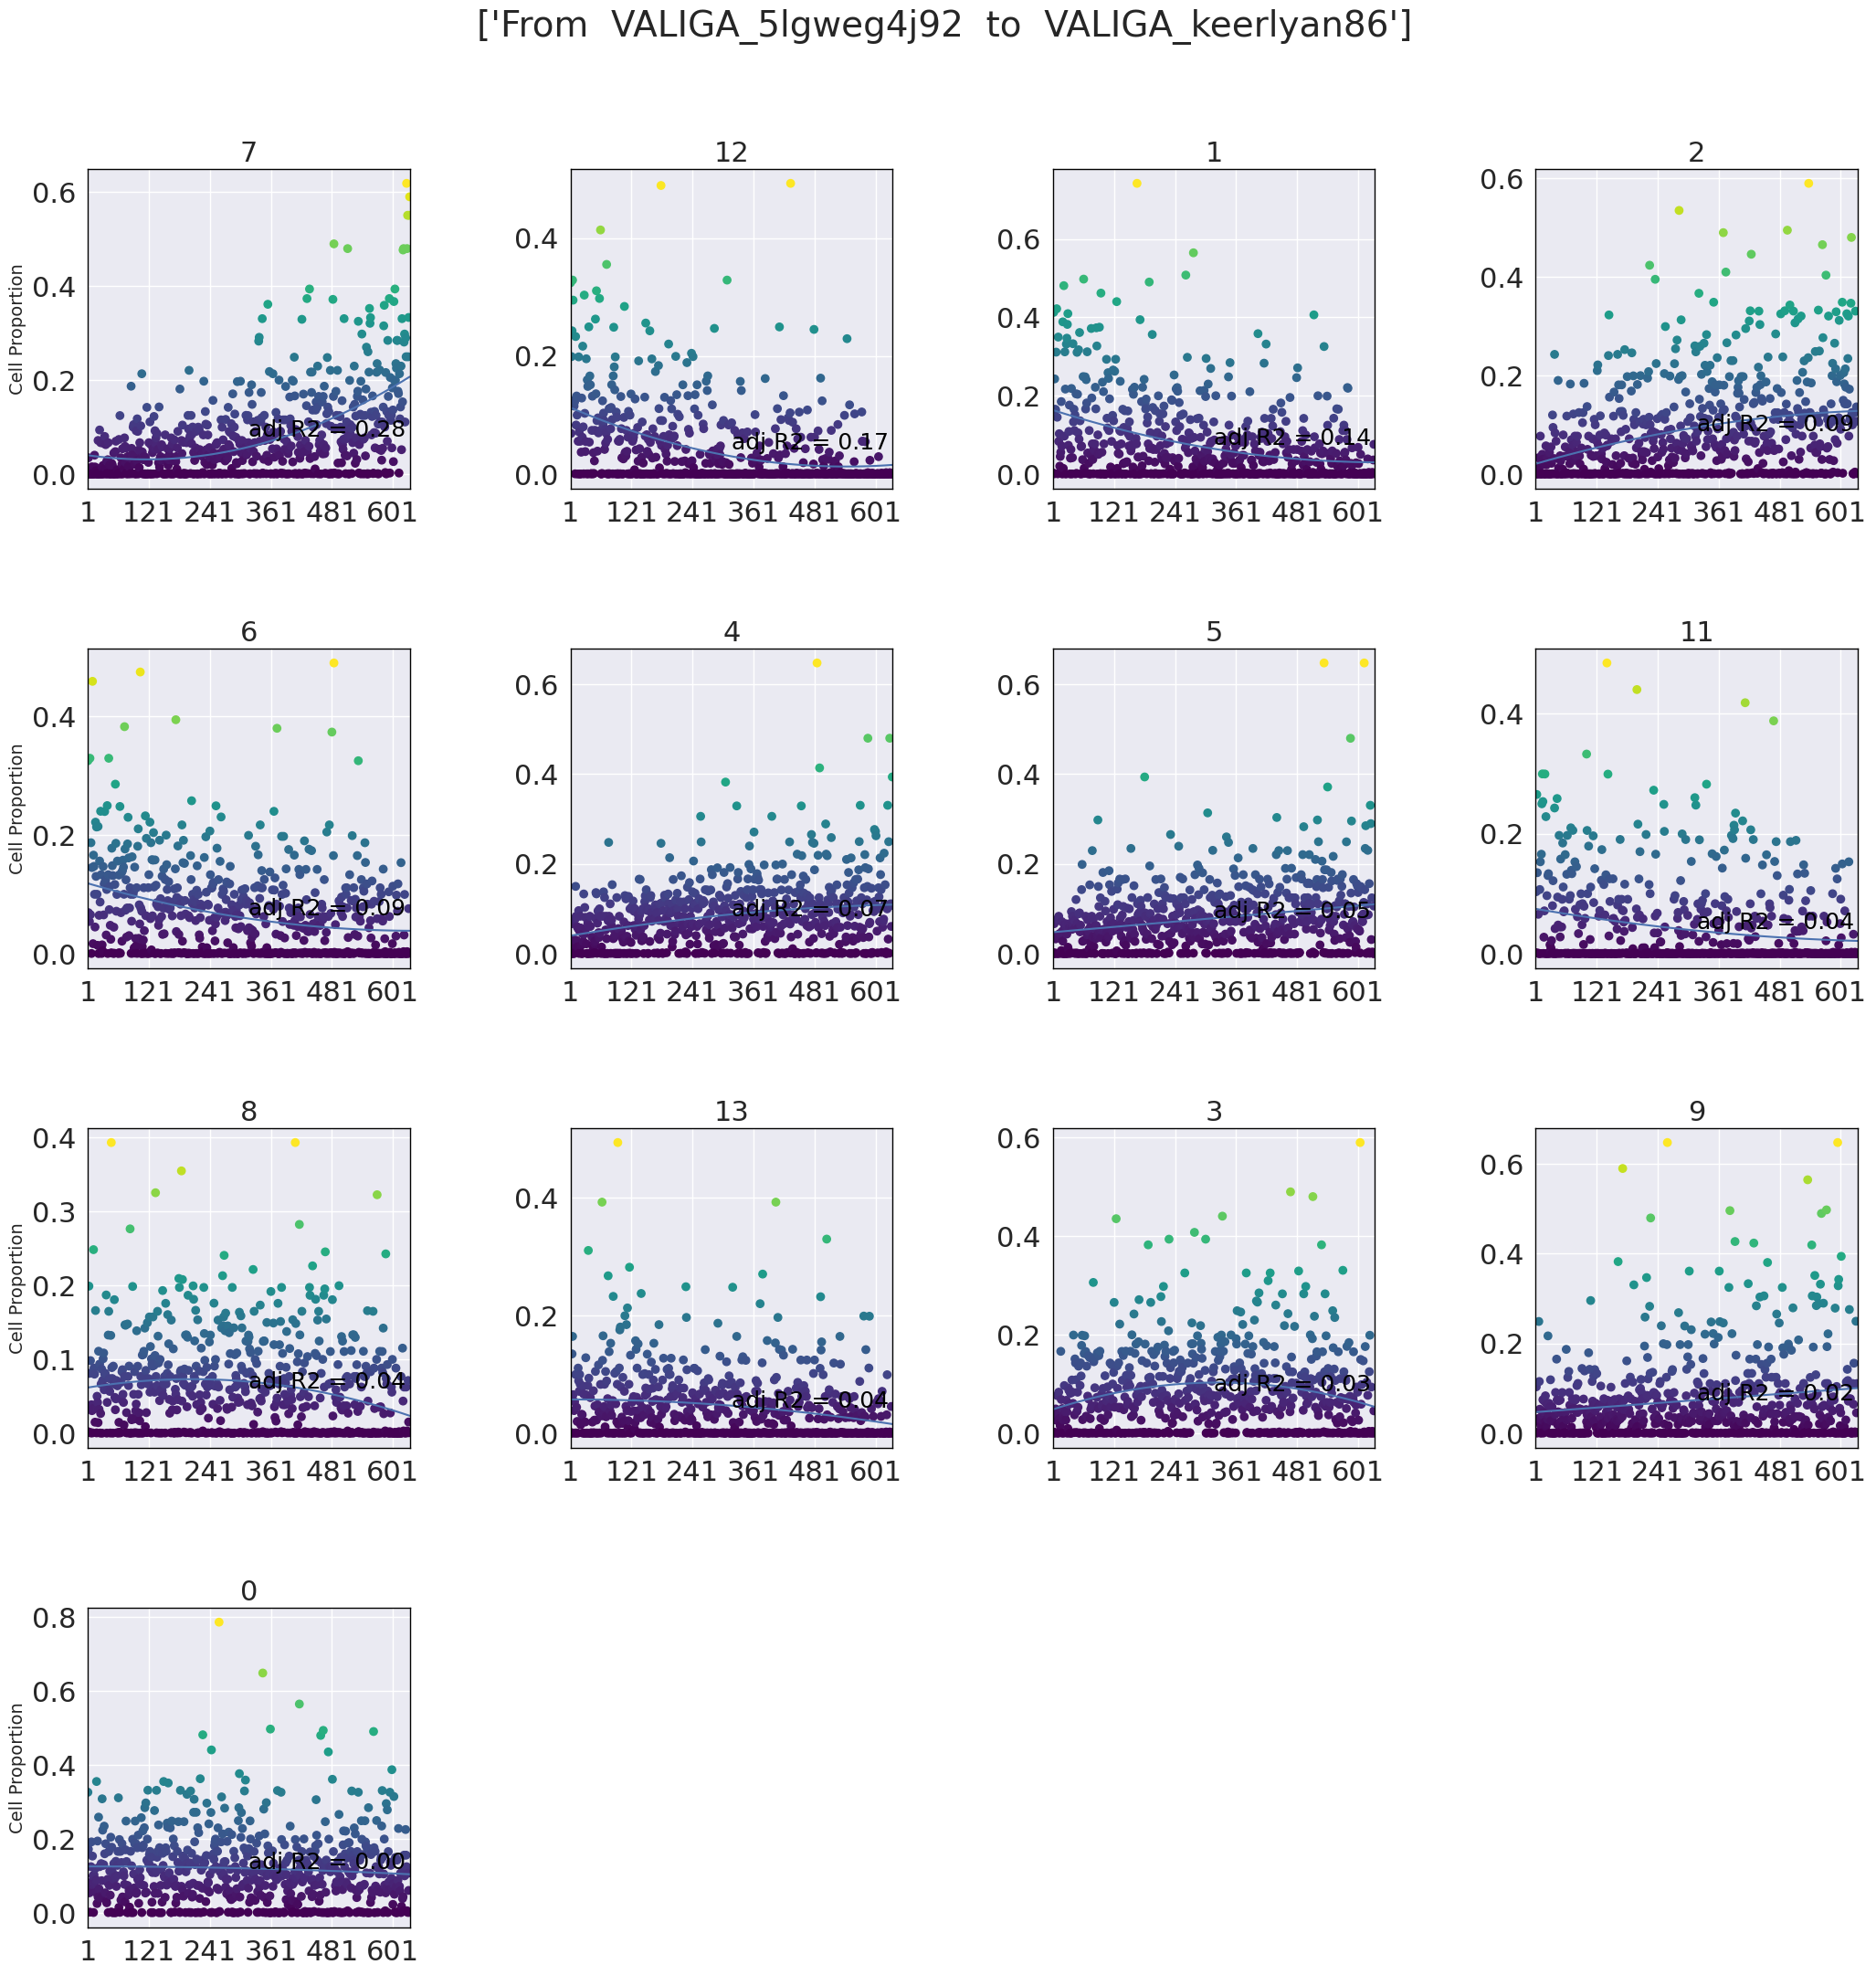

In [14]:
embedding_diff=emd_glomeruli+emd_tubuli #here we sum up the embeddings of Tubuli and glomeruli for next analysis
orders,cell_names=Cell_importance(Clu_rep,annot_glom,embedding_diff,real_labels,path=path_to_results,sort_axis='emb_x',width=30,height=35,xlim=120,p_val=0.5)

# Feature selection for Glomeruli based on Combination:

### Saving morphological features and map them with the obtained order by PILOT  (for Glomeruli)

In [15]:

data_glom['sampleID']=list(annot_glom['sampleID'])
joint=pd.merge(data_glom,orders,on='sampleID')
if not os.path.exists(path_to_results+'/cells/'):  
                os.makedirs(path_to_results+'/cells/')
joint.to_csv(path_to_results+'/cells/'+'All.csv')

### Morphological Feature Feature selection:
* You should have the same trajectories for Glomeruli and Tubuli with the tutorial to get the same order, otherwise redo the part of evauation for both and once you get the same trajectory try!

Name of Cell type : All
sparsity:6.486269746268921e-05
For this cell_type, p-value of  14 genes are statistically significant.
  Expression pattern  count
0        linear down      7
1          linear up      4
3       quadratic up      2
2     quadratic down      1
data saved successfully


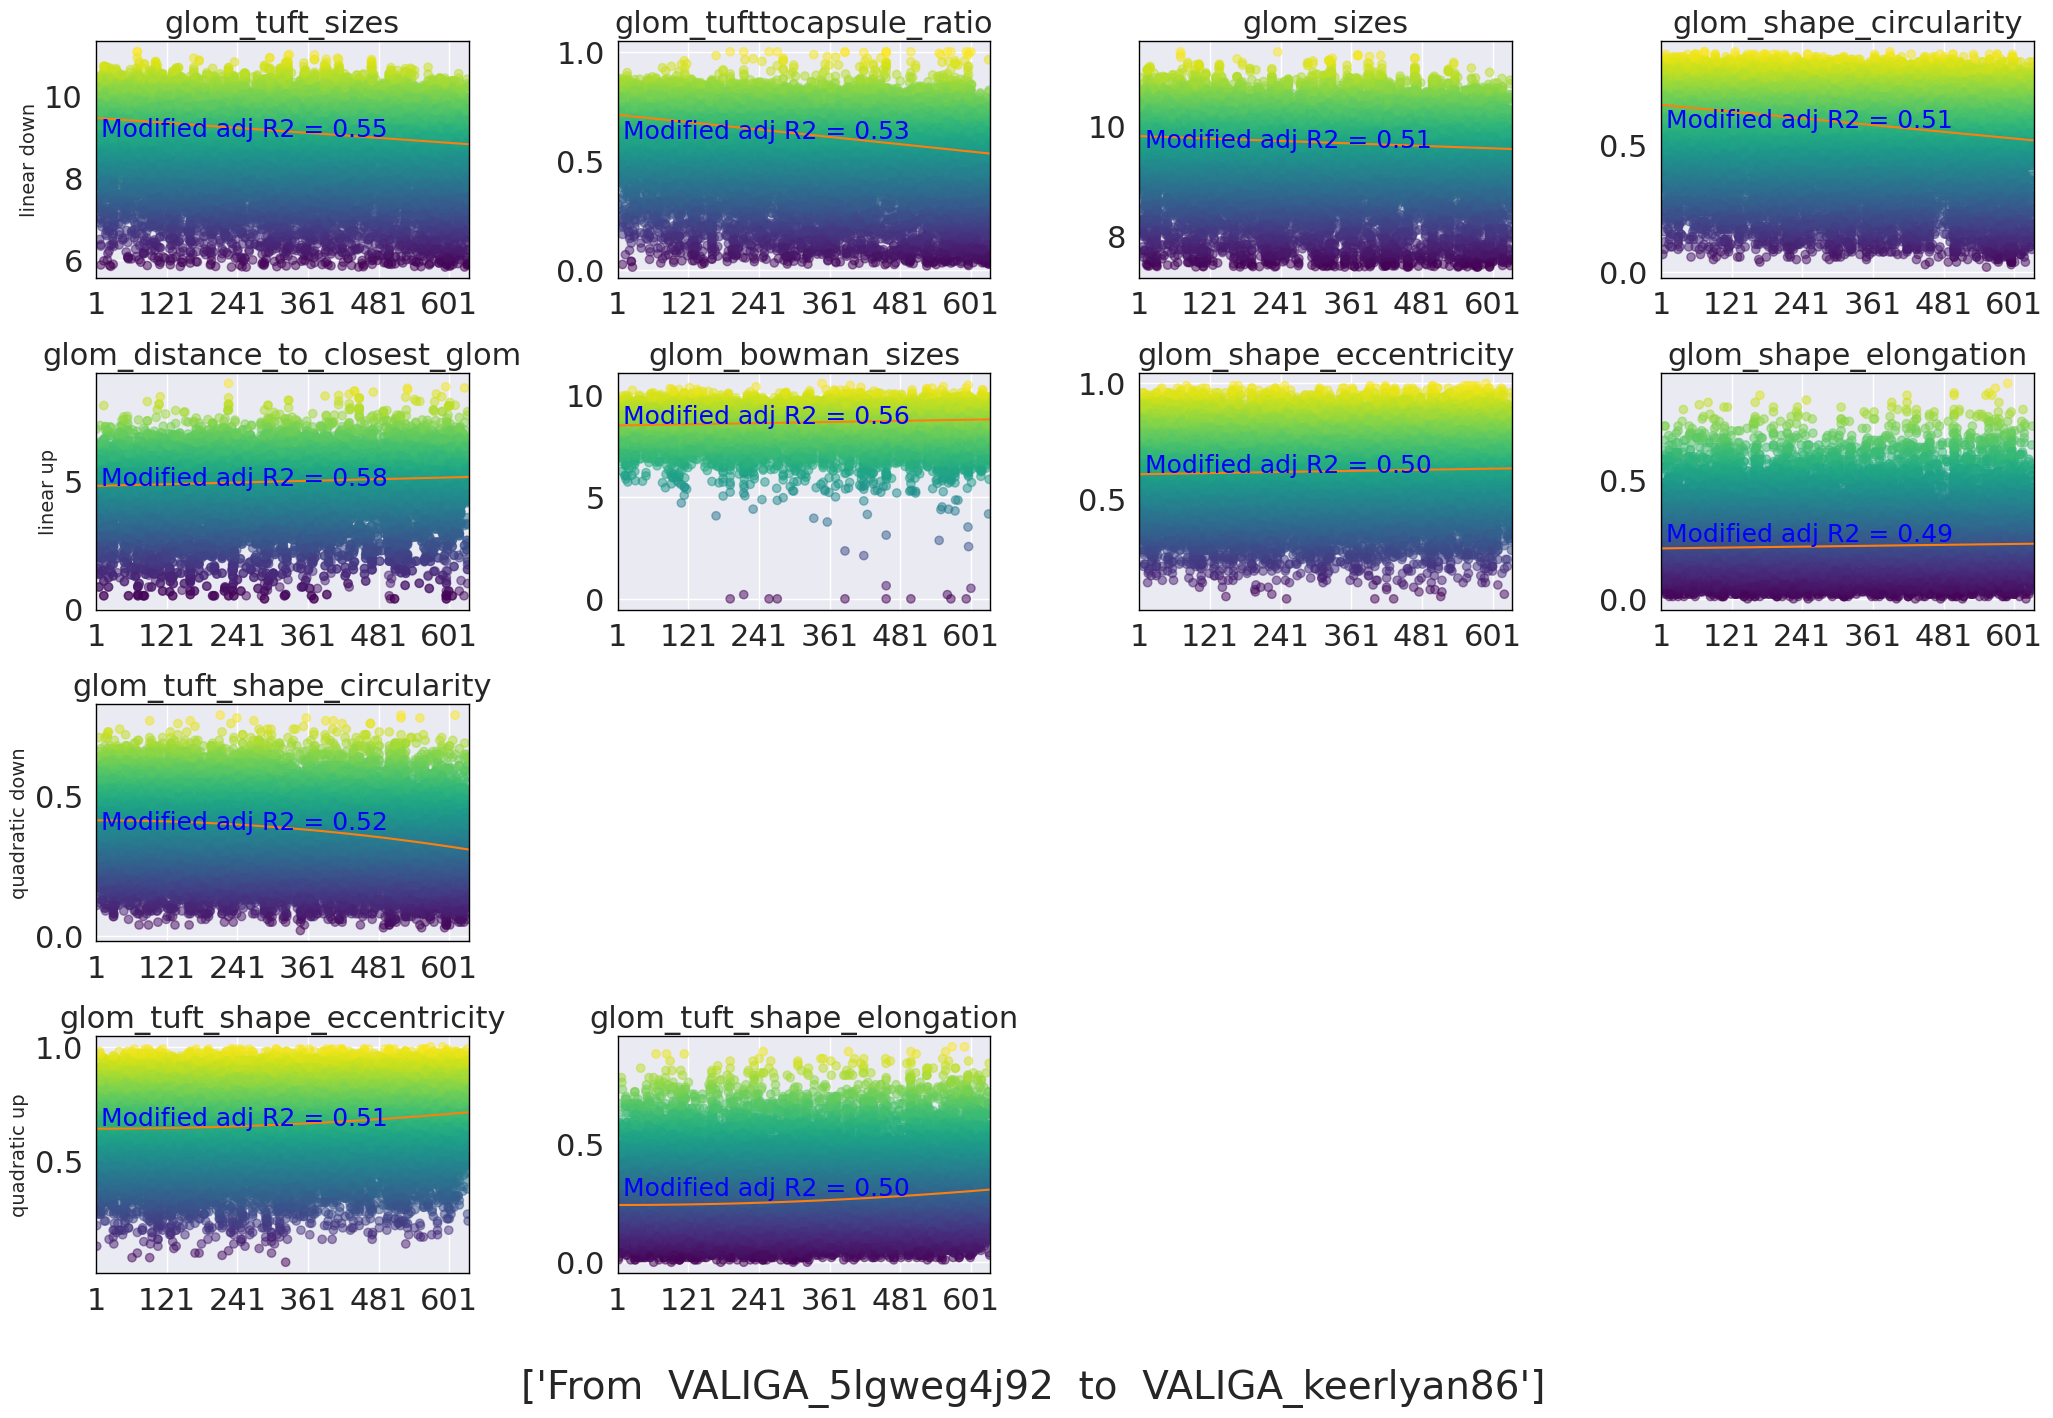

In [16]:
cell_n='All'
data =loadTarget(path_to_results+'/cells/', cell_n)
colss=['glom_sizes',
 'glom_distance_to_closest_glom',
 'glom_diameters',
 'glom_tuft_sizes',
 'glom_bowman_sizes']
for col in colss:
    data[col]=np.log(data[col]+1)
pro=proportions(data)
genes_importance(pro,data,path=path_to_results,name_cell=cell_n,col='Time_score',genes_index=list(range(0, 14)),p_value=0.01,max_iter_huber=500,epsilon_huber=1.35,x_lim=120,store_data=1,modify_r2=True)

# Feature slection for Tubuli based on Combination

### Saving morphological features and map them with the obtained order by PILOT  (for Tubuli)

In [17]:

path_to_results='Results_PILOT/Kidney_IgAN_T'
data_tubuli['sampleID']=list(annot_tubuli['sampleID'])
joint=pd.merge(data_tubuli,orders,on='sampleID')
if not os.path.exists(path_to_results+'/cells/'):  
                os.makedirs(path_to_results+'/cells/')
joint.to_csv(path_to_results+'/cells/'+'All.csv')

###  Morphological Feature selection

Name of Cell type : All
sparsity:0.0
For this cell_type, p-value of  3 genes are statistically significant.
  Expression pattern  count
0        linear down      2
1          linear up      1
data saved successfully


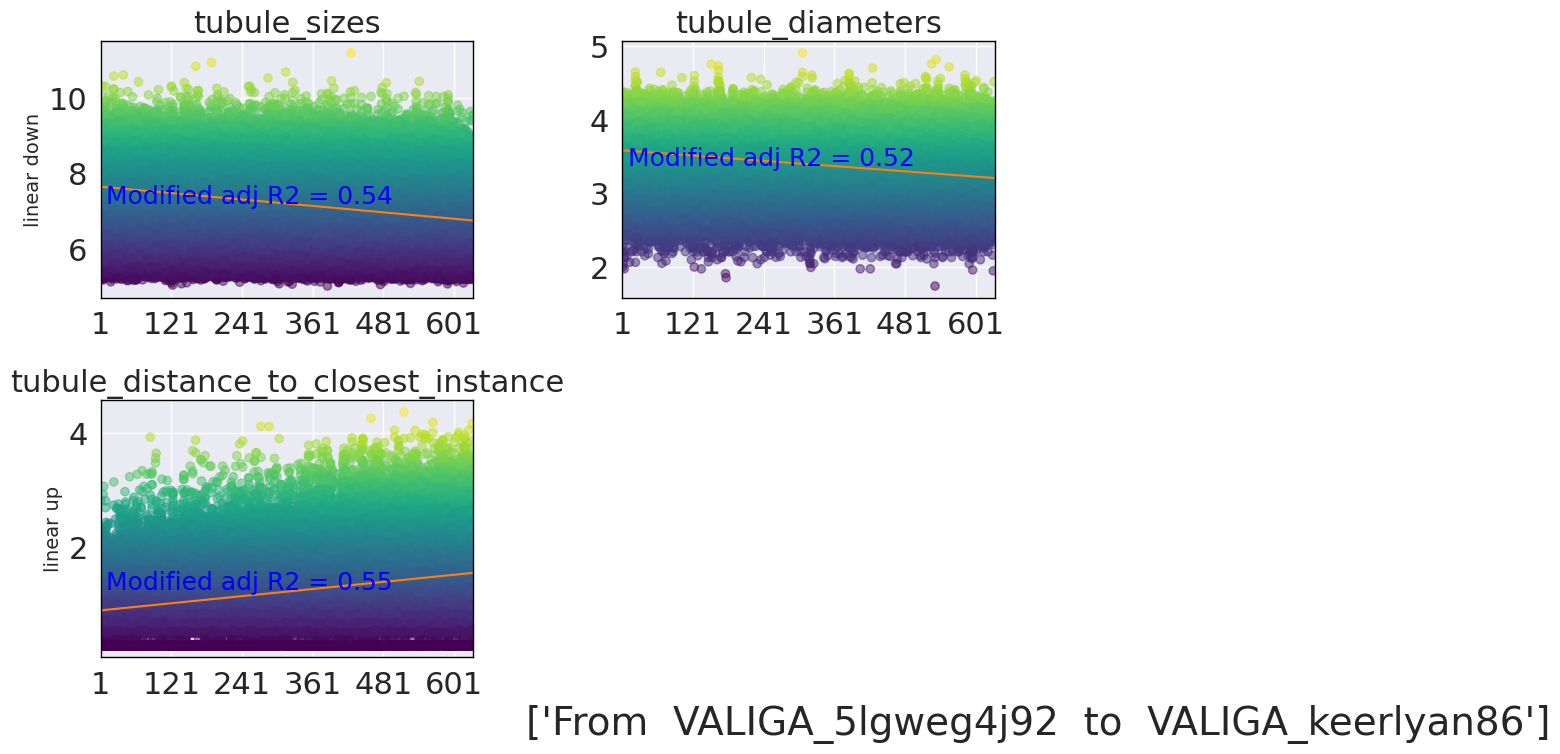

In [18]:
cell_n='All'
data =loadTarget(path_to_results+'/cells/', cell_n)
colss=['tubule_diameters',
 'tubule_sizes',
 'tubule_distance_to_closest_instance']
for col in colss:
    data[col]=np.log(data[col]+1)
pro=proportions(data)
genes_importance(pro,data,path=path_to_results,name_cell=cell_n,col='Time_score',genes_index=list(range(0, 3)),p_value=0.01,max_iter_huber=500,epsilon_huber=1.35,x_lim=120,store_data=1,modify_r2=True)